# Choosing Some Data Sets for Exemplar Data

Rob Edwards, Dec 9<sup>th</sup>

This is selecting some data sets from the WGS metagenomes that we have identied. 

As a background, Ben provided a list of 141,790 SRR IDs that they have identified as WGS metagenomes based on the annotations.

We developed [partie](https://github.com/linsalrob/partie/) to automatically detect WGS metagenomes from the SRA and have run it on 996,770 SRA datasets so far. Partie measures a few things, notably the frequency of *unique* *k*-mers (i.e. *k*-mers that appear only once). If you have a 16S amplicon data set, most of the *k*-mers appear many times since the 16S is so repetative. In contrast, if you have a random WGS metagenome, the *k*-mers are more unique.

Second, we compare to databases of 16S genes, prokaryotic genes, and phages. 

Next, we also consider the length of the dataset, and typically rule out anything less than 5 MB. This is because there are samples with [a single 150 bp read](https://www.ncbi.nlm.nih.gov/sra/?term=ERR1040181), and we can't accurately annotate them. However, this may be a bit low and we should perhaps increase this, because [many, many datasets](https://www.ncbi.nlm.nih.gov/bioproject/PRJNA348753) in the 5MB range are [reconstructed genomes](https://www.ncbi.nlm.nih.gov/sra/?term=SRR5326851). But there are also [plenty of real metagenomes](https://www.ncbi.nlm.nih.gov/sra/?term=SRR2090082) that are that size. *Note:* As of 12/11/18 I have specifically labeled the MAGs from [this study](https://www.ncbi.nlm.nih.gov/bioproject/PRJNA348753) and they do not appear as WGS datasets anymore.

Note that in the file below we have two columns: `Automatic Annotation` is our partie prediction without filtering by size and `Partie Classification` is after filtering by size. I don't bother including the orginal submittors designation, but could add it if requested.

I merged these two data sets, and at the moment we have:

Number | What | What that means
--- | --- | ---
85,200 | AGREE | partie and NCBI say they are WGS
56,476 | DISAGREE | partie says it is not WGS
80,312 | NCBI MISSED | NCBI hasn't processed yet
15 | PARTIE MISSED | partie hadn't processed because the data is not publicly available.

*Note:* these numbers are constantly changing as I am updating partie and NCBI is processing more data. The actual counts are provided below once we read the file.

This data is in the file `wgs_datasets.tsv.gz` that I have shared on slack and is in this directory (so you can run this notebook!). Note that it is a gzip file to save space but pandas don't care.

I am still blown away that even though we have processed almost 1,000,000 datasets with partie there are 40,503 we hadn't seen yet. Those are processing and will be done shortly.

To generate the test data for the pre-hackathon, I'm using the 61,421 metagenomes from the `AGREE` dataset. These are ones that we are sure are metagenomes.

Lets use panda to take a look at this data!

In [1]:
# set up the environment. It doesn't matter, but I usually organize all my imports at the top.
# import our environment
import os
import sys

from math import log,e,sqrt

%matplotlib inline
import pandas as pd
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# this is a neat trick for getting markdown in our output. It is totally superfluous :)
# see https://stackoverflow.com/questions/23271575/printing-bold-colored-etc-text-in-ipython-qtconsole
# for the inspiration
from IPython.display import Markdown, display
def printmd(string, color=None):
    colorstr = "<span style='color:{}'>{}</span>".format(color, string)
    display(Markdown(colorstr))

## Read the data

This just creates a dataframe from the file

In [3]:
df = pd.read_csv('wgs_datasets.tsv.gz', compression='gzip', sep='\t', header=0, dtype={'SRR': str, 'Status': str, 'NCBI Classification': str, 'Partie Classification': str, 'percent_unique_kmer': float, 'percent_16S': float, 'percent_phage': float, 'percent_Prokaryote': float, 'Partie Automatic Annotation': str, 'Size (bp)': int})
df.describe()

,percent_unique_kmer,percent_16S,percent_phage,percent_Prokaryote,Size (bp)
count,220129.000000,220129.000000,220129.000000,220129.000000,2.219880e+05
mean,69.142247,9.049184,1.605149,23.705094,2.198199e+09
std,32.284593,24.818937,8.011683,29.435871,6.142537e+09
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,53.142655,0.000000,0.000000,0.570000,4.979261e+07
50%,83.252405,0.110000,0.010000,10.890000,4.572294e+08
75%,94.742342,0.260000,0.170000,35.050000,1.805806e+09
max,100.000000,100.000000,100.000000,100.000000,2.730726e+11


### Adding a log length column

Its length data. Its not going to plot clearly, so we add a column with log of the size so we can see what they look like. Note that we log<sub>10</sub> this so it makes more sense.

In [4]:
df['log size']=df.apply(lambda x: log(x['Size (bp)'] + 1)/log(10), axis=1)

## How we compare

Do we agree or not?

In [5]:
df['Status'].value_counts()

AGREE          85200
NCBI MISSED    80312
DISAGREE       56476
Name: Status, dtype: int64

## Size distributions

Here is a quick histogram of the sizes of all the data, just so we get an idea.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f85f30ba9b0>,
      dtype=object)

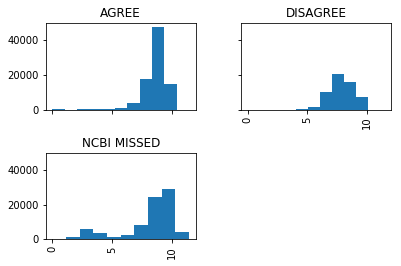

In [6]:
df.hist(by="Status", column='log size', sharex=True, sharey=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f85f3c08be0>,
      dtype=object)

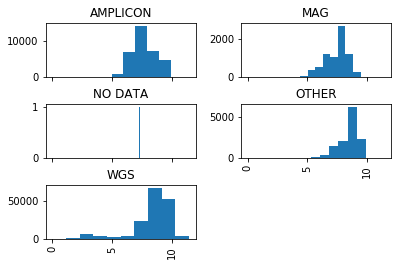

In [7]:
df.hist(by="Partie Classification", column='log size', sharex=True)

# Choose the random metagenomes

We just filter here for columns where we both agree that they are metagenomes. This is a robust set to work with, although once we have a pipeline running and we know how much computation we need, we should probably just do everything and see what falls out.

`dfa` is a data frame where we agree, obvs. 

In [8]:
dfa = df[df['Status'] == "AGREE"]
dfa.describe()

,percent_unique_kmer,percent_16S,percent_phage,percent_Prokaryote,Size (bp),log size
count,85200.000000,85200.000000,85200.000000,85200.000000,8.520000e+04,85200.000000
mean,87.154873,0.783626,0.348162,20.129823,1.211119e+09,8.619078
std,14.155867,6.404198,2.325103,20.562334,1.481037e+09,0.909995
min,0.400864,0.000000,0.000000,0.000000,0.000000e+00,0.000000
25%,82.620553,0.060000,0.000000,3.950000,1.548577e+08,8.189933
50%,92.379225,0.140000,0.020000,14.760000,6.386333e+08,8.805252
75%,96.864680,0.210000,0.110000,28.430000,1.631042e+09,9.212465
max,100.000000,100.000000,99.970000,100.000000,2.660719e+10,10.424999


# Sample 1 - A Random Selection

Lets random sample 1,000 datasets from our list where we `AGREE` that they are `WGS` samples.

`s1` is sample 1.

In [9]:
s1 = dfa.sample(1000)
s1.describe()

,percent_unique_kmer,percent_16S,percent_phage,percent_Prokaryote,Size (bp),log size
count,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000
mean,86.876736,0.725340,0.353320,20.283320,1.229511e+09,8.638614
std,14.086519,6.293896,2.141933,21.121683,1.497540e+09,0.856907
min,1.644659,0.000000,0.000000,0.000000,4.730000e+02,2.675778
25%,81.862022,0.060000,0.000000,3.670000,1.793633e+08,8.253734
50%,91.907969,0.140000,0.020000,14.685000,6.518189e+08,8.814126
75%,96.853869,0.210000,0.122500,27.997500,1.581370e+09,9.199033
max,99.747698,94.440000,40.420000,99.540000,1.057558e+10,10.024304


### Plot the data.

Remember that we have a cut off of 5MB (5 x 10<sup>6</sup> which explains the lower limit here.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f85f38dcf98>,
      dtype=object)

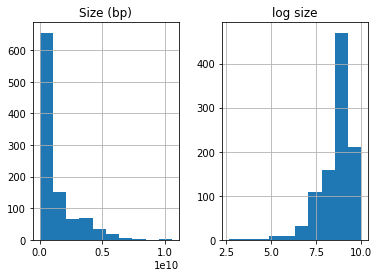

In [10]:
s1.hist(column=['Size (bp)', 'log size'])

### Print those IDs

These are those IDs, put into a file called `random_selection.txt`.

Remember, that the sampling here is random so each time you run it you'll get a different output!

In [11]:
with open("random_selection.txt", 'w') as out:
    out.write("\n".join(s1['SRR']))

# Sample 2 - A Size Selected Selection

This selection has three different sets, and I've chosen them to be `small`, `medium`, and `large`, a third of each. 

`small` : The 25<sup>th</sup> percentile is 4.5 x 10<sup>7</sup>, so we take 2 x 10<sup>7</sup> to 7 x 10<sup>7</sup>. 

`medium` : The 50<sup>th</sup> percentile is 4 x 10<sup>8</sup>, so we take 1.5 x 10<sup>8</sup> to 6.5 x 10<sup>8</sup>. 

`large` : The 75<sup>th</sup> percentile is 9 x 10<sup>8</sup>, so we take 6.5 x 10<sup>8</sup> to 1.5 x 10<sup>9</sup>. 

From each set, we choose 333 samples at random.

*Note:* When I wrote this description and code, these were the percentiles (shown in the output from the first `describe()` command). However, I'm adding a bit more data so they will change slightly but these are probably still appropriate.

`s2s`, `s2m`, and `s2l` are sample 2, small, medium, and large.

In [12]:
s2s = dfa[(dfa['Size (bp)'] > 2e7) & (dfa['Size (bp)'] < 7e7)].sample(333)
s2s.describe()

,percent_unique_kmer,percent_16S,percent_phage,percent_Prokaryote,Size (bp),log size
count,333.000000,333.000000,333.000000,333.000000,3.330000e+02,333.000000
mean,81.465422,0.990210,0.500601,19.691441,4.291404e+07,7.606960
std,15.221443,6.875892,5.102991,18.854068,1.419565e+07,0.153125
min,2.786466,0.000000,0.000000,0.000000,2.006086e+07,7.302349
25%,70.803934,0.070000,0.000000,7.270000,3.141446e+07,7.497130
50%,82.471402,0.120000,0.020000,14.070000,4.230971e+07,7.626440
75%,95.381593,0.190000,0.060000,26.970000,5.443274e+07,7.735860
max,99.663993,74.860000,90.480000,97.960000,6.990149e+07,7.844486


In [13]:
s2m = dfa[(dfa['Size (bp)'] > 1.5e8) & (dfa['Size (bp)'] < 6.5e8)].sample(333)
s2m.describe()

,percent_unique_kmer,percent_16S,percent_phage,percent_Prokaryote,Size (bp),log size
count,333.000000,333.000000,333.000000,333.000000,3.330000e+02,333.000000
mean,87.922587,0.260781,0.265556,20.017568,4.337466e+08,8.610003
std,13.161741,0.763566,0.868274,20.666559,1.368536e+08,0.164393
min,50.725036,0.000000,0.000000,0.020000,1.528022e+08,8.184130
25%,82.575520,0.060000,0.000000,5.030000,3.307915e+08,8.519554
50%,94.556400,0.150000,0.020000,12.970000,4.603392e+08,8.663078
75%,96.859597,0.240000,0.120000,28.120000,5.396950e+08,8.732148
max,99.576144,9.310000,8.670000,98.760000,6.488317e+08,8.812132


In [14]:
s2l = dfa[(dfa['Size (bp)'] > 6.5e8) & (dfa['Size (bp)'] < 1.5e9)].sample(333)
s2l.describe()

,percent_unique_kmer,percent_16S,percent_phage,percent_Prokaryote,Size (bp),log size
count,333.000000,333.000000,333.000000,333.000000,3.330000e+02,333.000000
mean,88.312597,0.400661,0.401832,22.065405,9.843322e+08,8.979766
std,13.210189,2.108317,1.330734,21.242400,2.451768e+08,0.107916
min,6.043282,0.000000,0.000000,0.010000,6.503525e+08,8.813149
25%,85.580440,0.080000,0.000000,6.010000,7.831092e+08,8.893822
50%,93.468928,0.160000,0.020000,17.410000,9.222411e+08,8.964844
75%,97.033932,0.220000,0.130000,31.160000,1.199463e+09,9.078987
max,99.494039,28.700000,13.470000,95.530000,1.499520e+09,9.175952


### join the small samples

Make one big data frame. Remember that append is not in place!

In [15]:
dfs = pd.DataFrame()
dfs = dfs.append([s2s, s2m, s2l])
dfs.describe()

,percent_unique_kmer,percent_16S,percent_phage,percent_Prokaryote,Size (bp),log size
count,999.000000,999.000000,999.000000,999.000000,9.990000e+02,999.000000
mean,85.900202,0.550551,0.389329,20.591471,4.869976e+08,8.398910
std,14.234679,4.183345,3.084148,20.286816,4.190145e+08,0.597814
min,2.786466,0.000000,0.000000,0.000000,2.006086e+07,7.302349
25%,77.185321,0.070000,0.000000,5.970000,5.460373e+07,7.737220
50%,92.284527,0.140000,0.020000,14.270000,4.603392e+08,8.663078
75%,96.596312,0.220000,0.090000,29.175000,7.830487e+08,8.893789
max,99.663993,74.860000,90.480000,98.760000,1.499520e+09,9.175952


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f85f38367f0>,
      dtype=object)

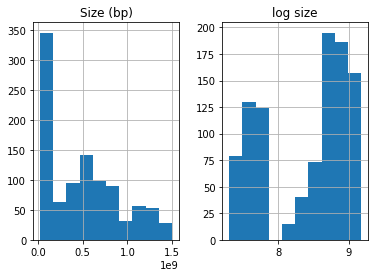

In [16]:
dfs.hist(column=['Size (bp)', 'log size'])

In [17]:
with open("size_selection.txt", 'w') as out:
    out.write("\n".join(dfs['SRR']))

# Sample 3 - Size and Phage Selection

In order to maximize our success of finding phages, we should use the data we have! As part of partie, we calculate the percent of reads that map to phage genomes.

We can use that to hopefully improve our success of finding phages in the metagenomes &ndash; especially in this trial phase.

Lets take our size selections again, and this time sort by phage counts, and use the top 333 rather than a random selection of metagenomes.

In the random selection above our percent phage ranges from 0 - 54%. Here our percent phage ranges from 5 - 100%. Hopefully we can find a phage or two!

In [18]:
s3s = dfa[(dfa['Size (bp)'] > 2e7) & (dfa['Size (bp)'] < 7e7)].sort_values(by='percent_phage', ascending=False).head(333)
s3m = dfa[(dfa['Size (bp)'] > 1.5e8) & (dfa['Size (bp)'] < 6.5e8)].sort_values(by='percent_phage', ascending=False).head(333)
s3l = dfa[(dfa['Size (bp)'] > 6.5e8) & (dfa['Size (bp)'] < 1.5e9)].sort_values(by='percent_phage', ascending=False).head(333)

dfp = pd.DataFrame()
dfp = dfp.append([s3s, s3m, s3l])
dfp.describe()

,percent_unique_kmer,percent_16S,percent_phage,percent_Prokaryote,Size (bp),log size
count,999.000000,999.000000,999.000000,999.000000,9.990000e+02,999.000000
mean,83.026045,0.872432,5.884304,46.369149,4.734907e+08,8.387335
std,14.296183,2.548711,5.825285,31.860959,4.101297e+08,0.596697
min,13.638484,0.000000,1.100000,0.000000,2.002338e+07,7.301537
25%,73.863133,0.140000,3.310000,16.350000,5.549288e+07,7.744237
50%,88.122049,0.210000,4.360000,40.590000,4.077483e+08,8.610392
75%,93.803437,0.340000,6.590000,81.460000,7.747141e+08,8.889141
max,99.908387,39.670000,90.480000,98.940000,1.499848e+09,9.176047


### Size Distribution

This looks about the same as the random selection. We could test it, but I don't think it's that important - we are just trying to optimize the workflow.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f85f3797da0>,
      dtype=object)

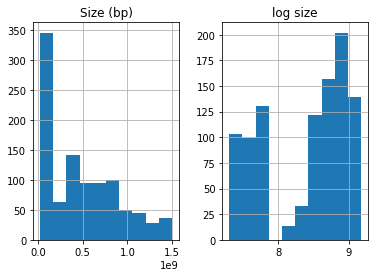

In [19]:
dfp.hist(column=['Size (bp)', 'log size'])

### Write the list out

In [20]:
with open("phage_size_selection.txt", 'w') as out:
    out.write("\n".join(dfp['SRR']))